In [56]:
### Function Imports
from OptionsFunctions import import_fx_data, plot_forex, daily_returns
import numpy as np
from scipy.stats import norm
import pandas as pd


In [57]:
### Call Function to Load in Rate Data (Get Spot Price S_0)
all_forex_pairs = [
        'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'AUDUSD=X', 'NZDUSD=X',
        'USDCAD=X', 'EURGBP=X', 'EURJPY=X', 'EURCHF=X', 'EURAUD=X', 'EURNZD=X',
        'EURCAD=X', 'GBPAUD=X', 'GBPJPY=X', 'GBPCHF=X', 'AUDJPY=X', 'AUDCHF=X',
        'AUDNZD=X', 'NZDJPY=X', 'NZDCHF=X', 'CADJPY=X', 'CADCHF=X', 'CHFJPY=X'
    ]
pair = 'USDEUR=X'
start_date = '2021-01-01'
forex_data = import_fx_data(pair, start_date)
# Get the Spot Price (Most recent FX rate value)
S_0 = forex_data[pair].iloc[-1]  # Extract the last value from the column 'USDEUR=X'
print('The Spot Price is:', round(S_0, 4))
K = 0.9500
print('The pre-determined Strike Price is:', K)


[*********************100%%**********************]  1 of 1 completed

The Spot Price is: 0.9332
The pre-determined Strike Price is: 0.95


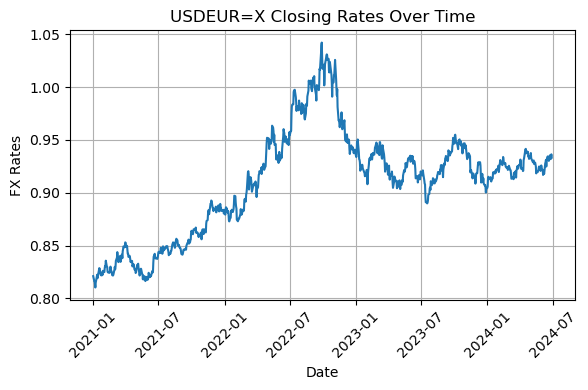

In [58]:
### Call Function to Plot FX Data
plot_pair = ['USDEUR=X']
plot_forex(forex_data, plot_pair)

In [59]:
### Function Call to Compute Daily Returns
daily_rets = daily_returns(forex_data)
print(daily_rets)

          Date  USDEUR=X
0   2021-01-04 -0.005749
1   2021-01-05 -0.000074
2   2021-01-06 -0.003957
3   2021-01-07 -0.003309
4   2021-01-08  0.005677
..         ...       ...
905 2024-06-24  0.001745
906 2024-06-25 -0.004190
907 2024-06-26  0.002157
908 2024-06-27  0.002763
909 2024-06-28 -0.003332

[910 rows x 2 columns]


In [60]:
### Function to Build Black Scholes (BSM) Model
def black_scholes(S_0, K, r, r_f, T, sigma, option_type):
    # Compute d_1 and d_2
    d_1 = (np.log(S_0 / K) + (r - r_f + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    #print(d_1)
    d_2 = d_1 - sigma * np.sqrt(T)
    #print(d_2)
    
    # Compute Option Premium and Greeks
    if option_type == 'call':
        option_price = S_0 * np.exp(-r_f * T) * norm.cdf(d_1) - K * np.exp(-r * T) * norm.cdf(d_2)
        delta = np.exp(-r_f * T) * norm.cdf(d_1)
        theta = (-S_0 * sigma * np.exp(-r_f * T) * norm.pdf(d_1) / (2 * np.sqrt(T)) 
                 - r * K * np.exp(-r * T) * norm.cdf(d_2)
                 + r_f * S_0 * np.exp(-r_f * T) * norm.cdf(d_1))
        rho = K * T * np.exp(-r * T) * norm.cdf(d_2)

    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d_2) - S_0 * np.exp(-r_f * T) * norm.cdf(-d_1)
        delta = -np.exp(-r_f * T) * norm.cdf(-d_1)
        theta = (-S_0 * sigma * np.exp(-r_f * T) * norm.pdf(d_1) / (2 * np.sqrt(T)) 
                 - r * K * np.exp(-r * T) * norm.cdf(-d_2)
                 + r_f * S_0 * np.exp(-r_f * T) * norm.cdf(-d_1))
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d_2)

    else:
        raise ValueError('Error: Incorrect Option Type, must input call or put')

    # Calculate Remaining Greeks
    gamma = np.exp(-r_f * T) * norm.pdf(d_1) / (S_0 * sigma * np.sqrt(T))
    vega = S_0 * np.exp(-r_f * T) * np.sqrt(T) * norm.pdf(d_1)

    # Probabilities
    prob_ITM_call = norm.cdf(d_1)
    prob_ITM_put = norm.cdf(-d_1)
    prob_exercise_call = norm.cdf(d_2)
    prob_exercise_put = norm.cdf(-d_2)

    # Print and explain values
    print(f"Option Type: {option_type}")
    print(f"Option Price: {option_price:.4f}")
    print(f"Delta: {delta:.4f} - Delta represents the sensitivity of the option's price to changes in the underlying asset's price (prob option finishes ITM)")
    print(f"Gamma: {gamma:.4f} - Gamma measures the rate of change of Delta with respect to changes in the underlying price.")
    print(f"Theta: {theta:.4f} - Theta measures the sensitivity of the option's price to the passage of time.")
    print(f"Rho: {rho:.4f} - Rho measures the sensitivity of the option's price to changes in the risk-free interest rate.")
    print(f"Vega: {vega:.4f} - Vega measures the sensitivity of the option's price to changes in the volatility of the underlying asset.")
    print(f"Probability ITM (Call): {prob_ITM_call:.4f} - Probability the call option finishes In The Money.")
    print(f"Probability ITM (Put): {prob_ITM_put:.4f} - Probability the put option finishes In The Money.")
    print(f"Probability of Exercise (Call): {prob_exercise_call:.4f} - Probability the call option will be exercised.")
    print(f"Probability of Exercise (Put): {prob_exercise_put:.4f} - Probability the put option will be exercised.")

    # Return Option Premium and Greeks
    return option_price, delta, gamma, theta, rho, vega, prob_ITM_call, prob_ITM_put, prob_exercise_call, prob_exercise_put

### Call Function to Compute Option Premium and Greeks
sigma = 0.08 # Assumed to be constant which allows for a closed-form solution to pricing European-style options
r = 0.02
r_f = 0.01
T = 1
option_price, delta, gamma, theta, rho, vega, prob_ITM_call, prob_ITM_put, prob_exercise_call, prob_exercise_put = black_scholes(S_0, K, r, r_f, T, sigma, option_type = 'call')



Option Type: call
Option Price: 0.0261
Delta: 0.4721 - Delta represents the sensitivity of the option's price to changes in the underlying asset's price (prob option finishes ITM)
Gamma: 5.2817 - Gamma measures the rate of change of Delta with respect to changes in the underlying price.
Theta: -0.0186 - Theta measures the sensitivity of the option's price to the passage of time.
Rho: 0.4145 - Rho measures the sensitivity of the option's price to changes in the risk-free interest rate.
Vega: 0.3680 - Vega measures the sensitivity of the option's price to changes in the volatility of the underlying asset.
Probability ITM (Call): 0.4769 - Probability the call option finishes In The Money.
Probability ITM (Put): 0.5231 - Probability the put option finishes In The Money.
Probability of Exercise (Call): 0.4451 - Probability the call option will be exercised.
Probability of Exercise (Put): 0.5549 - Probability the put option will be exercised.


In [62]:
### Function to Implement the Hedge (Compute Hedge Position and hedged returns)
def delta_hedge(fx_rets, delta, long_pos):
    hedge_pos = -delta * long_pos
    hedged_rets = fx_rets + hedge_pos
    return hedged_rets


In [63]:
### Implement Backtesting



In [64]:
### Evaluate Performance

